# Topic Modeling

In [2]:
from tmtoolkit.corpus import Corpus, lemmatize, to_lowercase, remove_chars, filter_clean_tokens, remove_punctuation
from tmtoolkit.corpus import corpus_num_tokens, corpus_tokens_flattened
from tmtoolkit.corpus import dtm
from tmtoolkit.corpus import vocabulary
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

## Data Loading

The dataset is open source dataset to fine-tunine foundation language model to follow instruction.

In [3]:
import json

instruction_examples = []

with open('./wizardlm_alpaca_dolly_orca.jsonl', 'r') as file:
    for line in file:
        data = json.loads(line)
        instruction_examples.append(data)

In [5]:
len(instruction_examples)

104179

The instruction example is to teach the language model to follow the instruction. Basically, it is the instruction e.g., "What are the three primary colors?". We want to teach LLM (Large Language Model) to answer our question instead of generating what LLM normally generate. In the actual training, we pad the text with special tokens (###).

```
### Instruction:
Who are you?

### Output:
I am AI chat model. May I know how I can help you?
```


In [14]:
instruction_examples[0]

{'instruction': 'What are the three primary colors?',
 'input': '',
 'system': 'You are a teacher. Given a task, you explain in simple steps what the task is asking, any guidelines it provides and how to use those guidelines to find the answer.',
 'output': 'The task is asking for the three primary colors. Primary colors are colors that cannot be created by mixing other colors together. The guidelines that we have is that we need to identify the three primary colors. \n\nTo find the answer, we need to know that there are two sets of primary colors: additive and subtractive. Additive primary colors are red, green, and blue. These are the primary colors of light and are used in devices such as computer monitors and televisions. Subtractive primary colors are cyan, magenta, and yellow, which are the primary colors of pigments and are used in printing. \n\nHowever, the most commonly known primary colors are red, blue, and yellow, which are the primary colors for mixing paints. So, to answe

The system message is the header that is telling the model what the model needs to behaviour and it comes with 15 system messages to choose from. For the purpose of topic modeling, we will be only interested in `instruction` and `output` because we want to visualize what training dataset topics are distributed.

In [17]:
instruction_texts = [example['instruction'] + ' ' + example['output'] for example in instruction_examples]

## EDA

In [18]:
instruction_texts[0]

'What are the three primary colors? The task is asking for the three primary colors. Primary colors are colors that cannot be created by mixing other colors together. The guidelines that we have is that we need to identify the three primary colors. \n\nTo find the answer, we need to know that there are two sets of primary colors: additive and subtractive. Additive primary colors are red, green, and blue. These are the primary colors of light and are used in devices such as computer monitors and televisions. Subtractive primary colors are cyan, magenta, and yellow, which are the primary colors of pigments and are used in printing. \n\nHowever, the most commonly known primary colors are red, blue, and yellow, which are the primary colors for mixing paints. So, to answer the question, the three primary colors are red, blue, and yellow.'

In [9]:
from wordcloud import STOPWORDS

In [6]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

### Unigram

In [19]:
from collections import defaultdict

unigram = defaultdict(int)

for example in instruction_texts:
    for word in generate_ngrams(example, 1):
        unigram[word] += 1

In [24]:
import pandas as pd

df_unigram = pd.DataFrame(sorted(unigram.items(), key=lambda x: x[1])[::-1])

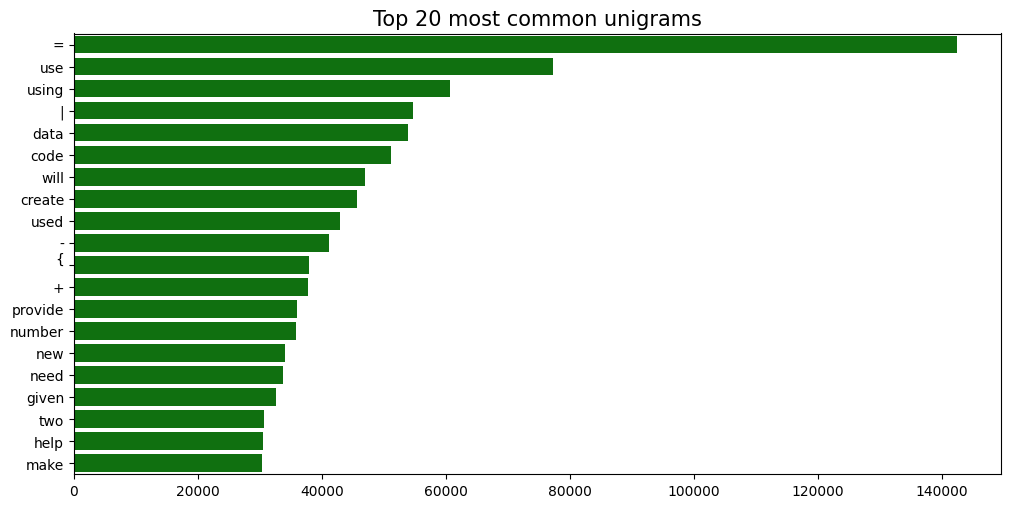

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

N = 20

fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()

sns.barplot(y=df_unigram[0].values[:N], x=df_unigram[1].values[:N], ax=axes, color='green')

axes.set_title(f'Top {N} most common unigrams', fontsize=15)


plt.show()

### Bigrams

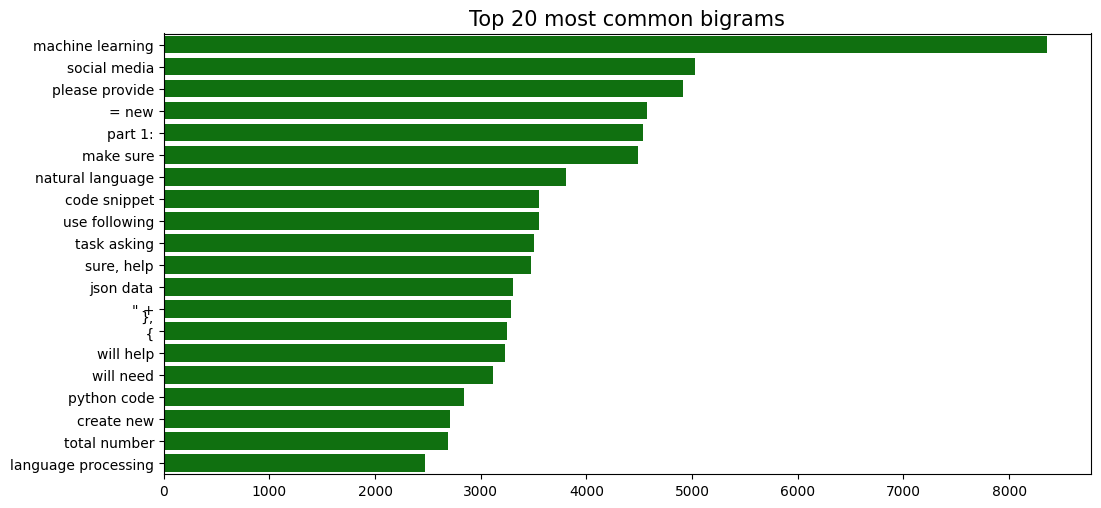

In [40]:
bigrams = defaultdict(int)

for example in instruction_texts:
    for word in generate_ngrams(example, 2):
        bigrams[word] += 1
        
df_bigrams = pd.DataFrame(sorted(bigrams.items(), key=lambda x: x[1])[::-1])

N = 20

fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()

sns.barplot(y=df_bigrams[0].values[:N], x=df_bigrams[1].values[:N], ax=axes, color='green')

axes.set_title(f'Top {N} most common bigrams', fontsize=15)


plt.show()

### Trigrams

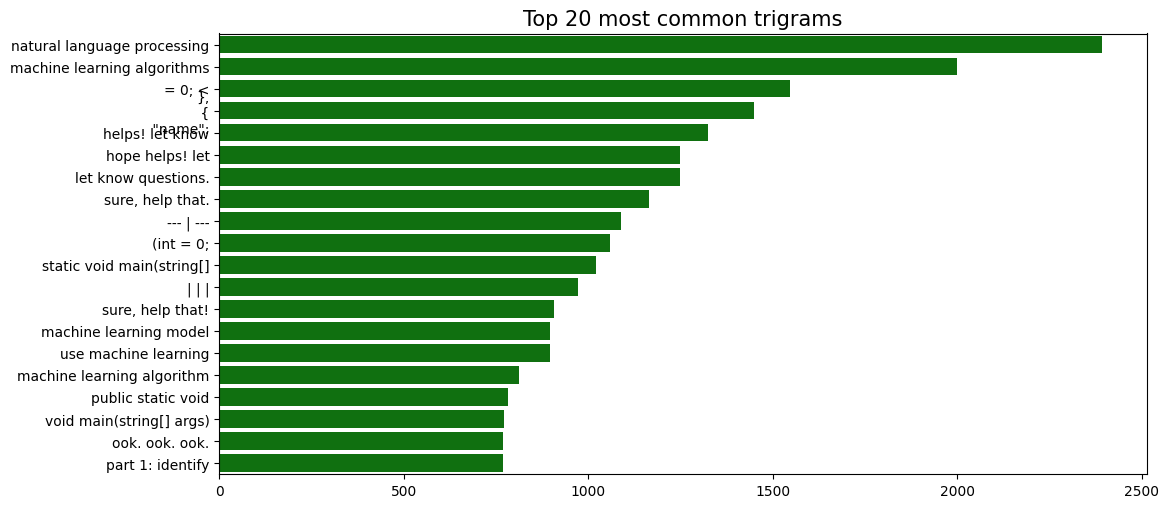

In [41]:
trigrams = defaultdict(int)

for example in instruction_texts:
    for word in generate_ngrams(example, 3):
        trigrams[word] += 1
        
df_trigrams = pd.DataFrame(sorted(trigrams.items(), key=lambda x: x[1])[::-1])

N = 20

fig, axes = plt.subplots(ncols=1, figsize=(10, 5))
plt.tight_layout()

sns.barplot(y=df_trigrams[0].values[:N], x=df_trigrams[1].values[:N], ax=axes, color='green')

axes.set_title(f'Top {N} most common trigrams', fontsize=15)


plt.show()

### Building text corpus

In [43]:
def build_corpus(texts, lang="en"):
    corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)

    lemmatize(corpus)
    to_lowercase(corpus)
    remove_punctuation(corpus)
    filter_clean_tokens(corpus, remove_shorter_than=2)

    return corpus

In [44]:
instruction_corpus = build_corpus(instruction_texts)

In [45]:
var_params = [{ 'n_topics': k, 'alpha': 1 / k } for k in range(10, 71, 10)]

const_params = {
    'n_iter': 100,
    'random_state': 42,
    'eta': 0.7
}

In [46]:
document_term_matrix, doc_labels_, vocab_ = dtm(instruction_corpus, return_doc_labels=True, return_vocab=True)

## Evaluating different parameters

In [ ]:
eval_results = evaluate_topic_models(
    document_term_matrix,
    varying_parameters=var_params,
    constant_parameters=const_params,
    coherence_mimno_2011_top_n=10,
    coherence_mimno_2011_include_prob=True,
    return_models=True
)

In [48]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_topics[:3]

[(10,
  {'model': <lda.lda.LDA at 0x7f3d578b1930>,
   'cao_juan_2009': 0.2587956200663117,
   'coherence_mimno_2011': -504.41223397167926}),
 (20,
  {'model': <lda.lda.LDA at 0x7f3d577cce80>,
   'cao_juan_2009': 0.18472801630300256,
   'coherence_mimno_2011': -520.8576803049191}),
 (30,
  {'model': <lda.lda.LDA at 0x7f3d577cdf30>,
   'cao_juan_2009': 0.14270503114354002,
   'coherence_mimno_2011': -571.6238081843425})]

/home/light/anaconda3/envs/topic_model/lib/python3.10/site-packages/tmtoolkit/topicmod/visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


(<Figure size 600x400 with 2 Axes>,
 [array([<Axes: title={'center': 'cao_juan_2009'}>,
         <Axes: title={'center': 'coherence_mimno_2011'}>], dtype=object)])

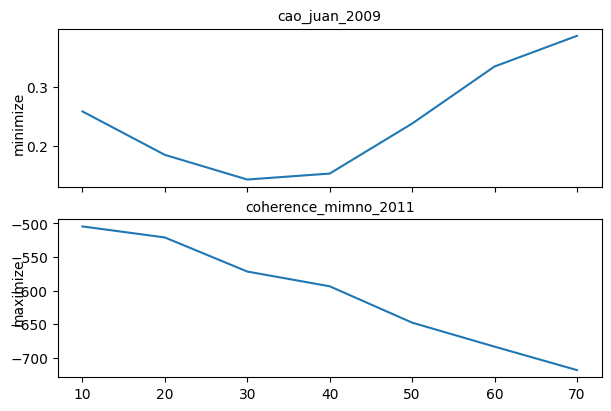

In [49]:
from tmtoolkit.topicmod.visualize import plot_eval_results

plot_eval_results(eval_results_by_topics)

### Best Topic Model

In [51]:
best_tm = [m for k, m in eval_results_by_topics if k == 30][0]['model']
best_tm.n_topics, best_tm.alpha, best_tm.eta

(30, 0.03333333333333333, 0.7)

### Generating topic words

In [52]:
import numpy as np

from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

vocab_ = np.array(vocab_)

doc_lengths_bg = doc_lengths(document_term_matrix)
topic_labels = generate_topic_labels_from_top_words(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    doc_labels_,
    np.array(vocab_),
    lambda_=2.0
)

In [53]:
topic_labels

array(['1_object_explain_describe_state', '2_1_2_3_number', '3_1_2_3_4',
       '4_create_text_cat_add', '5_1_sentence_follow_word',
       '6_sentence_word_give_1', '7_use_help_1_2',
       '8_change_cause_impact_lead', '9_help_1_2_3',
       '10_sentence_word_1_2', '11_use_energy_1_2',
       '12_create_use_color_2', '13_help_2_3_1',
       '14_book_movie_follow_character', '15_sentence_verb_give_word',
       '16_1_2_3_world', '17_area_triangle_length_right',
       '18_1_use_2_step', '19_object_class_method_age', '20_2_1_3_help',
       '21_card_heart_sentence_need', '22_tree_node_root_child',
       '23_datum_use_step_2', '24_1_2_3_create',
       '25_give_sentence_word_1', '26_time_find_help_like',
       '27_create_use_2_1', '28_animal_family_1_2',
       '29_water_process_plant_form', '30_2_1_3_4'], dtype='<U31')

### Result Discussion

According to this topic, it makes sense because I have a general idea of what training dataset look like. The dataset is used to teach the language model to do story telling, writing and reading comprehension. And, half of the data is writing code though I believe, some part of that will be removed by preprocessing.

In [54]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_topic_word = ldamodel_top_topic_words(
    best_tm.topic_word_,
    vocab_,
    row_labels=topic_labels
)

In [56]:
top_topic_word[:10]

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
1_object_explain_describe_state,object (0.01022),force (0.008721),theory (0.007286),quantum (0.005432),law (0.005372),motion (0.004505),particle (0.003848),universe (0.003728),principle (0.003609),gravity (0.003459)
2_1_2_3_number,number (0.02664),1 (0.02272),2 (0.01851),3 (0.01688),list (0.01432),5 (0.01249),4 (0.01175),function (0.009967),string (0.009845),element (0.009473)
3_1_2_3_4,1 (0.01429),2 (0.01157),ingredient (0.009289),add (0.008905),3 (0.007966),cup (0.007667),food (0.007529),recipe (0.007081),4 (0.006483),dish (0.006377)
4_create_text_cat_add,html (0.01357),cat (0.01345),dog (0.008662),tag (0.007326),text (0.006238),head (0.004902),create (0.004435),body (0.003845),page (0.003752),title (0.003627)
5_1_sentence_follow_word,dick (0.000405),️ (0.0003632),ishmael (0.0003215),katniss (0.000238),peeta (0.000238),moby (0.0001962),whale (0.0001545),chapter (0.0001545),ahab (0.0001545),behaviour (0.0001127)
6_sentence_word_give_1,word (0.04465),sentence (0.0416),give (0.01773),text (0.01088),phrase (0.009525),usage (0.009102),explanation (0.00867),follow (0.008229),task (0.00799),example (0.007179)
7_use_help_1_2,ai (0.01543),technology (0.01293),system (0.01069),datum (0.009522),use (0.007635),provide (0.007401),human (0.006925),help (0.006592),improve (0.00635),device (0.006341)
8_change_cause_impact_lead,change (0.01941),climate (0.01535),cause (0.01473),impact (0.01001),global (0.009772),lead (0.00707),effect (0.00637),warming (0.005884),weather (0.005845),article (0.00567)
9_help_1_2_3,help (0.01059),people (0.009412),work (0.009015),student (0.008633),time (0.007961),way (0.006195),provide (0.006048),learn (0.005833),1 (0.005766),life (0.005739)


In [15]:
from tmtoolkit.topicmod.visualize import parameters_for_ldavis

ldavis_params = parameters_for_ldavis(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    document_term_matrix,
    vocab_
)

In [58]:
from tmtoolkit.topicmod.evaluate import metric_coherence_mimno_2011

coh = metric_coherence_mimno_2011(
    best_tm.topic_word_,
    document_term_matrix,
    top_n=10,
    include_prob=True
)
coh

array([-595.61209591, -467.15560223, -517.99961866, -568.73905997,
       -817.19424249, -482.59498713, -501.11701619, -520.41648407,
       -514.07166216, -771.66406107, -508.94444703, -558.34178856,
       -491.3219427 , -592.24707558, -486.35362177, -528.05005594,
       -528.82178588, -515.4057245 , -717.30233031, -470.75833131,
       -770.91956006, -652.5281202 , -487.12575716, -546.41492872,
       -800.71142495, -520.07649511, -494.42175646, -714.99140696,
       -563.06458231, -444.34828014])

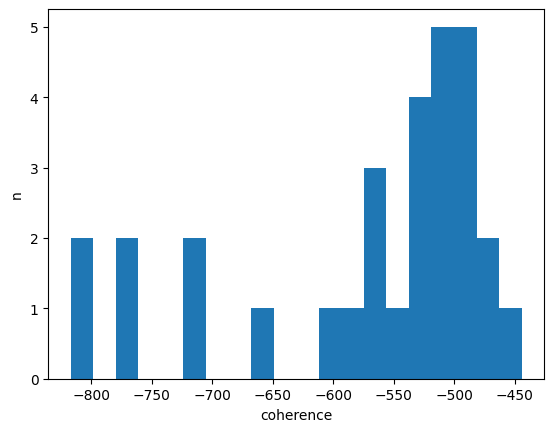

In [59]:
import matplotlib.pyplot as plt

plt.hist(coh, bins=20)
plt.xlabel('coherence')
plt.ylabel('n')
plt.show()

In [18]:
import pyLDAvis

In [19]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(**ldavis_params)

In [20]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.038118 -0.022691       1        1   3.487567
1      0.140511 -0.121031       2        1   8.373147
2      0.204791  0.039760       3        1   7.967018
3      0.052602  0.210904       4        1   4.286366
4      0.035977 -0.058181       5        1   5.161210
5      0.112379 -0.014623       6        1   5.472132
6     -0.163495 -0.007229       7        1   0.060136
7     -0.165304 -0.004154       8        1   0.109911
8     -0.034904 -0.009902       9        1   1.852164
9     -0.057594 -0.061866      10        1   2.044779
10    -0.167548 -0.008172      11        1   0.196854
11     0.236005  0.019810      12        1   9.101761
12     0.259458 -0.034605      13        1  10.389926
13    -0.163783 -0.007273      14        1   0.070038
14     0.026755  0.018655      15        1   3.185638
15    -0.148904  0.013820      16        1   0.559836
16     0.042651 -0.038199      17        1   3.773409
17     0.063149  0.189862      18        1   4.306886
18    -0.161344 -0.016918      19        1   0.222553
19    -0.001300 -0.083379      20        1   3.352053
20    -0.161966 -0.017213      21        1   0.312181
21     0.014005 -0.060916      22        1   2.438967
22     0.048950 -0.064205      23        1   3.160613
23     0.051959  0.080458      24        1   4.883010
24    -0.060302 -0.032079      25        1   1.893974
25     0.149925 -0.096333      26        1   5.178003
26     0.028804  0.007130      27        1   2.573095
27    -0.085427  0.040656      28        1   1.262341
28    -0.106137 -0.043100      29        1   1.508993
29    -0.028029  0.181013      30        1   2.815438, topic_info=           Term          Freq         Total Category  logprob  loglift
58465  sentence  11548.000000  11548.000000  Default  30.0000  30.0000
71286      word   8152.000000   8152.000000  Default  29.0000  29.0000
20470     datum  10089.000000  10089.000000  Default  28.0000  28.0000
46213    number   9554.000000   9554.000000  Default  27.0000  27.0000
19909  customer   8071.000000   8071.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
4533          5    628.179386  13082.579002  Topic30  -5.1062   0.5338
24890     equal    394.379017   1209.862444  Topic30  -5.5717   2.4491
68720       use    561.857792  15254.790445  Topic30  -5.2178   0.2687
4926          6    482.137895   6314.460071  Topic30  -5.3708   0.9977
45142      need    488.167131  12237.080526  Topic30  -5.3584   0.3485

[1850 rows x 6 columns], token_table=       Topic      Freq Term
term                       
0          1  0.004281    0
0          2  0.000428    0
0          3  0.000428    0
0          4  0.250037    0
0          5  0.000428    0
...      ...       ...  ...
73315     20  0.043840    🎉
73315     22  0.043840    🎉
73315     24  0.043840    🎉
73315     26  0.043840    🎉
73315     29  0.043840    🎉

[22891 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

: 

In conclusion, the model performs well. The visualization is quite insightful. It really helps me to make sense of the dataset. The topic one talks about solar system, and about physics questions. Topic 3 talks about machine learning itself. That's pretty cool discovery.

In the future work, I would try to incorporate with more datasets and try to tune the parameters to get better results. I would also try to use other topic modeling methods to see if I can get better results. At the model, I also explored with BERT Topic. Please refer to the bert notebook.